In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/pupil/pupil_trials.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/pupil/pupil_trials.csv'

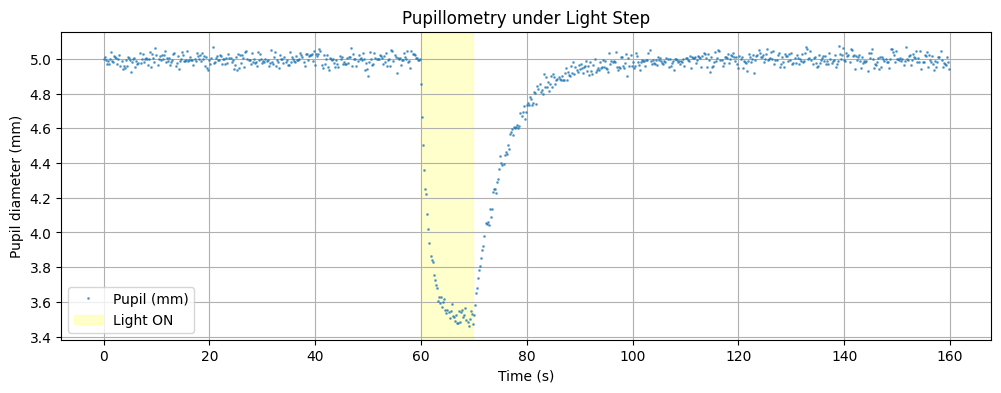

In [2]:
t = df["t_s"].values
y = df["pupil_mm"].values
lux = df["lux"].values
on_mask = (lux >= 500)           # our simple “light on” detector
t_on = t[on_mask].min()
t_off = t[on_mask].max()

plt.figure(figsize=(12,4))
plt.plot(t, y, '.', ms=2, alpha=0.6, label="Pupil (mm)")
plt.axvspan(t_on, t_off, color='yellow', alpha=0.2, label="Light ON")
plt.xlabel("Time (s)"); plt.ylabel("Pupil diameter (mm)")
plt.title("Pupillometry under Light Step")
plt.legend(); plt.grid(True); plt.show()

In [3]:
from scipy.optimize import curve_fit

# Baseline: mean pupil before the step (e.g., 20s window before t_on)
baseline_window = (t >= t_on-20) & (t < t_on)
baseline_mm = float(np.mean(y[baseline_window]))

# Minimum after light onset within 15s window
post_window = (t >= t_on) & (t <= t_on+15)
min_idx = np.argmin(y[post_window])
t_min = float(t[post_window][min_idx])
y_min = float(y[post_window][min_idx])

# Percent constriction
pct_constriction = 100.0 * (baseline_mm - y_min) / baseline_mm

# Latency to 10% of total constriction (from t_on)
target_10 = baseline_mm - 0.10*(baseline_mm - y_min)
# find first time y <= target_10 after t_on
lat_mask = (t >= t_on) & (t <= t_on+5)  # search up to 5s
lat_candidates = t[lat_mask][y[lat_mask] <= target_10]
latency_10pct = float(lat_candidates[0] - t_on) if len(lat_candidates) else np.nan

# Recovery time constant τ: fit exponential on recovery (t >= t_off)
rec_mask = t >= t_off
t_rec = t[rec_mask] - t_off
y_rec = y[rec_mask]

def rec_model(ts, A, tau, C):
    # A*exp(-t/tau) + C
    return A*np.exp(-ts/tau) + C

# Initial guesses: A ~ (y_min - baseline), tau ~ 5s, C ~ baseline
p0 = [y_min - baseline_mm, 5.0, baseline_mm]
try:
    popt, _ = curve_fit(rec_model, t_rec, y_rec, p0=p0, maxfev=10000)
    A_hat, tau_hat, C_hat = map(float, popt)
    tau_recovery = abs(tau_hat)
except Exception:
    tau_recovery = np.nan

metrics = dict(
    baseline_mm=round(baseline_mm,3),
    min_mm=round(y_min,3),
    t_on=float(t_on),
    t_off=float(t_off),
    t_min=float(t_min),
    pct_constriction=round(pct_constriction,2),
    latency_10pct_s=round(latency_10pct,3) if not np.isnan(latency_10pct) else None,
    tau_recovery_s=round(tau_recovery,3) if not np.isnan(tau_recovery) else None
)
metrics

{'baseline_mm': 4.996,
 'min_mm': 3.463,
 't_on': 60.0,
 't_off': 69.8,
 't_min': 69.0,
 'pct_constriction': 30.69,
 'latency_10pct_s': 0.2,
 'tau_recovery_s': 6.015}

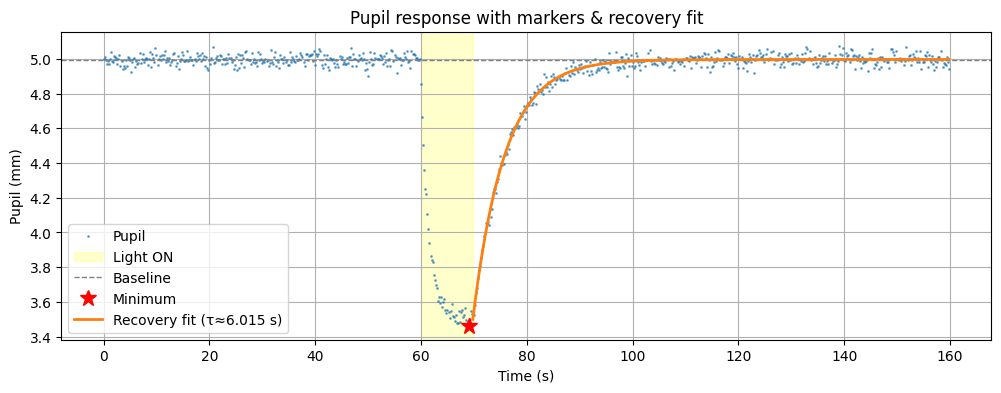

In [4]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t, y, '.', ms=2, alpha=0.6, label="Pupil")
ax.axvspan(t_on, t_off, color='yellow', alpha=0.2, label="Light ON")
ax.axhline(metrics["baseline_mm"], color='gray', lw=1, ls='--', label="Baseline")
ax.plot([t_min],[metrics["min_mm"]],'r*', ms=12, label="Minimum")

# recovery fit line (if available)
if metrics["tau_recovery_s"] is not None:
    t_fit = np.linspace(t_off, t[-1], 400)
    y_fit = rec_model(t_fit-t_off, A_hat, tau_hat, C_hat)
    ax.plot(t_fit, y_fit, '-', lw=2, label=f"Recovery fit (τ≈{metrics['tau_recovery_s']} s)")

ax.set_xlabel("Time (s)"); ax.set_ylabel("Pupil (mm)")
ax.set_title("Pupil response with markers & recovery fit")
ax.grid(True); ax.legend(loc='best'); plt.show()

In [5]:
# Figures
plt.figure(figsize=(12,4))
plt.plot(t, y, '.', ms=2, alpha=0.6)
plt.axvspan(t_on, t_off, color='yellow', alpha=0.2)
plt.xlabel("Time (s)"); plt.ylabel("Pupil (mm)")
plt.title("Pupillometry under Light Step")
plt.grid(True)
plt.savefig("../report/pupil_timeseries.png", dpi=200, bbox_inches="tight")
plt.close()

# Metrics text
with open("../report/pupil_metrics.txt","w") as f:
    for k,v in metrics.items():
        f.write(f"{k}: {v}\n")

"Saved ../report/pupil_timeseries.png and ../report/pupil_metrics.txt ✅"

'Saved ../report/pupil_timeseries.png and ../report/pupil_metrics.txt ✅'